#Connect GDrive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ROOT_DIR = '/content/gdrive/MyDrive/THESIS_ImprovedYOLO11'

In [ ]:
!ls

gdrive	sample_data


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

#Testing and Counting Object

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Image_12785_jpg.rf.e8f7f4f9e76a89198d57a053c3d71b7c.jpg to Image_12785_jpg.rf.e8f7f4f9e76a89198d57a053c3d71b7c (1).jpg


##Preprocess Input Image

In [ ]:
import os
import time
from PIL import Image
import cv2
import skimage.draw as drw
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

%matplotlib inline
import matplotlib
from google.colab.patches import cv2_imshow
import statistics

In [ ]:
# Dapatkan nama file yang diunggah
file_name = list(uploaded.keys())[0]

# Path lengkap file
file_path = f"/content/{file_name}"

print(f"File yang diunggah: {file_name}")
print(f"Path lengkap file: {file_path}")

File yang diunggah: Image_12785_jpg.rf.e8f7f4f9e76a89198d57a053c3d71b7c (1).jpg
Path lengkap file: /content/Image_12785_jpg.rf.e8f7f4f9e76a89198d57a053c3d71b7c (1).jpg


In [ ]:
img_bgr = cv2.imread(file_path)

In [ ]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

###HSRGAN

In [ ]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [ ]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [ ]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
def low2highImg(image, modelTrain = model):
    with tf.device('/CPU:0'):  # jalankan di CPU
        h_res_img = preprocess_image(image)
        low_res_img = downscale_image(tf.squeeze(h_res_img))
        high_res_img = modelTrain(low_res_img)
        high_res_img = tf.squeeze(high_res_img)
    return high_res_img

In [ ]:
# Membuat variabel yang berbeda pada setiap iterasi
ori2_varString = []
for i in range(1):
  img_bgr = file_name
  globals()[f"image_ori2"] = img_bgr
  ori2_varString.append("image_ori2")
# Mengubah setiap string menjadi array
ori2_var = [eval(string) for string in ori2_varString]

In [ ]:
import torch

if torch.cuda.is_available():
    print("✅ GPU tersedia:", torch.cuda.get_device_name(0))
else:
    print("❌ Tidak ada GPU.")

✅ GPU tersedia: NVIDIA A100-SXM4-40GB


In [ ]:
# Membuat variabel yang berbeda pada setiap iterasi
ori_high_res_varString = []
for i in range(1):
  img_ori = ori2_var[i]
  globals()[f"highResImg"] = low2highImg(img_ori)
  ori_high_res_varString.append("highResImg")
# Mengubah setiap string menjadi array
ori_high_res_var = [eval(string) for string in ori_high_res_varString]

In [ ]:
def show_images2(images_var,title):
    num_rows = 1
    num_cols = 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8))
    fig.suptitle(title)

    # Check if axes is a single Axes object
    if not isinstance(axes, np.ndarray):
        axes = [axes]  # Wrap it in a list to iterate

    for i, ax in enumerate(axes):  # Remove .flat and iterate directly
        image = images_var[i]
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
        ax.imshow(image)
        ax.set_title(f"Image {i+1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

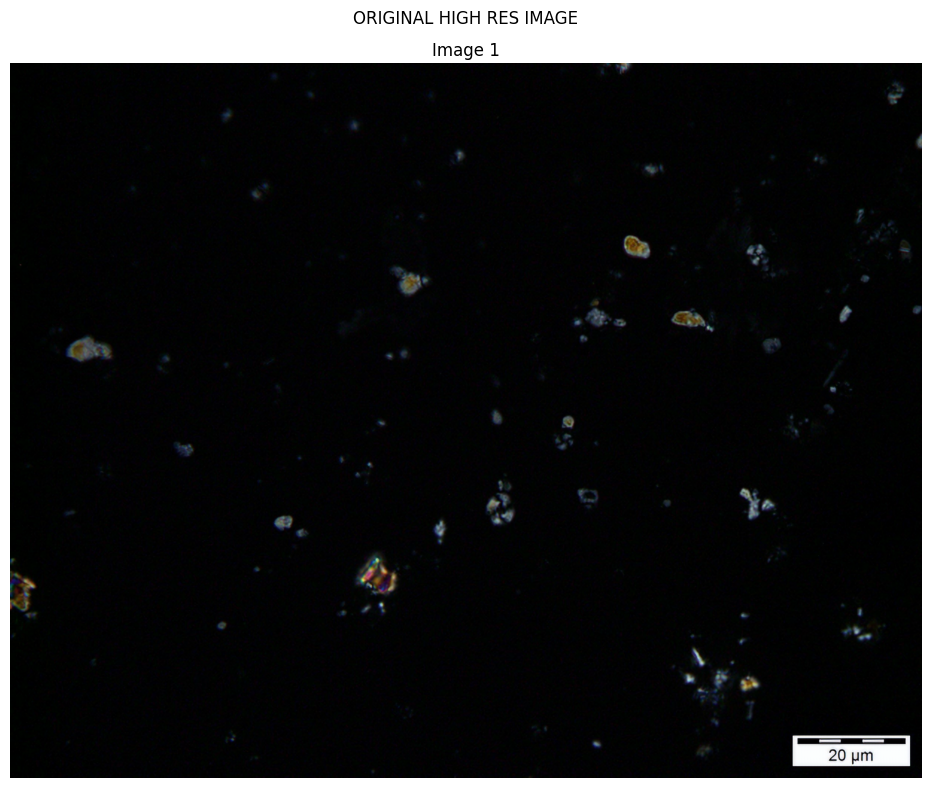

In [ ]:
show_images2(ori_high_res_var, "ORIGINAL HIGH RES IMAGE")

In [ ]:
from PIL import Image
from numpy import asarray
output_HRes = "/content/"
for i in range(1):
  image_high_res = ori_high_res_var[i]
  numpydata = asarray(image_high_res)
  image_high_res2 = cv2.cvtColor(numpydata, cv2.COLOR_BGR2RGB)
  cv2.imwrite(f"{output_HRes}image_HRes({str(i+1)}).jpg",image_high_res2)

###Invert Image(Optional)

In [ ]:
def invert_image(img, plot_hist=False):
    # Invert the image
    inverted_img = 255 - img

    if plot_hist:
        for i in range(inverted_img.shape[2]):
            plt.hist(inverted_img[:, :, i].ravel(), bins=256, alpha=0.5, label=f'Channel {i}')
        plt.title('Histogram of Inverted Image')
        plt.legend()
        plt.show()

    return inverted_img

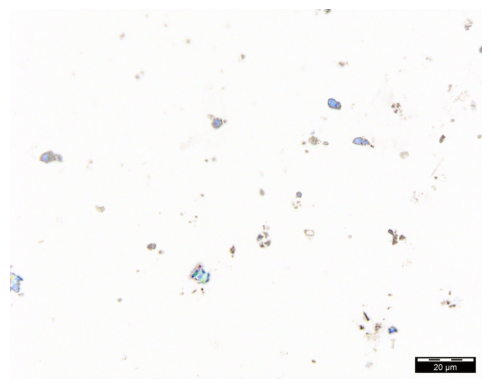

In [ ]:
HRes_img_bgr = "image_HRes(1).jpg"
# Load the image data using cv2.imread()
Hres_img_bgr = cv2.imread(HRes_img_bgr)
Hres_img_rgb = cv2.cvtColor(Hres_img_bgr, cv2.COLOR_BGR2RGB)
invert_img = invert_image(Hres_img_rgb)
plt.imshow(invert_img)
plt.axis('off')  # Matikan sumbu
plt.show()

###MeanSTD Contrast Stratching

In [ ]:
def stretch(img,sigma =3,plot_hist=False):
    stretched = np.zeros(img.shape)
    for i in range(img.shape[2]):  #looping through the bands
        band = img[:,:,i] # copiying each band into the variable `band`
        if np.min(band)<0: # if the min is less that zero, first we add min to all pixels so min becomes 0
            band = band + np.abs(np.min(band))
        band = band / np.max(band)
        band = band * 255 # convertaning values to 0-255 range
        if plot_hist:
            plt.hist(band.ravel(), bins=256) #calculating histogram
            plt.show()
        # plt.imshow(band)
        # plt.show()
        std = np.std(band)
        mean = np.mean(band)
        max = mean+(sigma*std)
        min = mean-(sigma*std)
        band = (band-min)/(max-min)
        band = band * 255
        # this streching cuases the values less than `mean-simga*std` to become negative
        # and values greater than `mean+simga*std` to become more than 255
        # so we clip the values ls 0 and gt 255
        band[band>255]=255
        band[band<0]=0
        print('band',i,np.min(band),np.mean(band),np.std(band),np.max(band))
        if plot_hist:
            plt.hist(band.ravel(), bins=256) #calculating histogram
            plt.show()
        stretched[:,:,i] = band
    stretched = stretched.astype('int')
    return stretched

In [ ]:
# Fungsi untuk menentukan apakah citra dominan gelap atau terang
def adaptiveInvertContrastStratching(image):
    # Menghitung rata-rata pixel
    average_pixel_value = np.mean(image)

    # Menentukan dominasi gelap atau terang
    if average_pixel_value < 90:
        img_rgb = image
        invert_image_Img = invert_image(img_rgb)
        result = stretch(invert_image_Img)
    else:
        result = stretch(image)

    return result


band 0 0.0 129.89194738548898 18.383041810644098 140.02230072711154
band 1 0.0 129.94294694749925 17.44031254726474 139.00974963211166
band 2 0.0 129.9306608729467 16.972331012163764 137.89939534827397


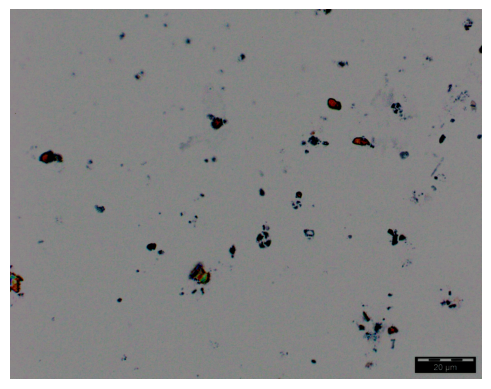

True

In [ ]:
result_img = adaptiveInvertContrastStratching(Hres_img_bgr)
plt.imshow(result_img)
plt.axis('off')  # Matikan sumbu
plt.show()

output_path = "/content/result_image.jpg"

# Simpan gambar
cv2.imwrite(output_path, result_img)

##Counting

In [ ]:
from ultralytics import YOLO

# Muat model YOLO yang telah dilatih sebelumnya
model = YOLO('/content/gdrive/MyDrive/THESIS_ImprovedYOLO11/runs/detect/train/weights/best.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Jalankan deteksi pada citra
image_path = '/content/result_image.jpg'
results = model(image_path)

# Ekstrak informasi deteksi
detections = results[0].boxes
class_names = model.names  # Mendapatkan nama kelas dari model
object_counts = {}

# Hitung jumlah objek per kelas
for box in detections:
    class_id = int(box.cls[0])  # ID kelas (angka)
    class_name = class_names[class_id]  # Nama kelas
    object_counts[class_name] = object_counts.get(class_name, 0) + 1

# Cetak jumlah objek per kelas
print("Jumlah objek per kelas:")
for class_name, count in object_counts.items():
    print(f"{class_name}: {count}")


image 1/1 /content/result_image.jpg: 512x640 2 Coccolith-XPLs, 25.9ms
Speed: 3.1ms preprocess, 25.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)
Jumlah objek per kelas:
Coccolith-XPL: 2


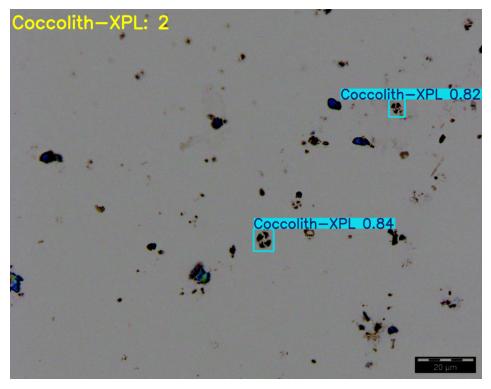

In [ ]:
# Anotasi citra hasil deteksi
annotated_image = results[0].plot()

# Tambahkan teks untuk setiap kelas
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.7
color = (0, 255, 0)  # Warna hijau
thickness = 2
y_offset = 50

# Tambahkan teks untuk setiap kelas
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 3  # Ukuran font lebih besar
color = (0, 255, 255)  # Warna biru
thickness = 10  # Ketebalan font
y_offset = 100  # Jarak vertikal awal

for class_name, count in object_counts.items():
    text = f"{class_name}: {count}"
    cv2.putText(
        annotated_image,
        text,
        (10, y_offset),  # Posisi teks
        font,
        font_scale,
        color,
        thickness
    )
    y_offset += 110  # Tambahkan jarak antar baris teks

# Tampilkan citra dengan anotasi
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()